In [85]:
import osmnx as ox
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize



In [135]:
def load_berlin_road_network():
    """
    Load the road network for Berlin using OSMNx API.

    Returns:
        networkx.MultiDiGraph: Road network graph for Berlin.
    """
    # Get the road network for Berlin
    G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
    
    return G

def plot_network(G):
    """
    Plot the road network graph.

    Args:
        G (networkx.MultiDiGraph): Road network graph.

    Returns:
        tuple: Matplotlib figure and axis.
    """
    fig, ax = ox.plot_graph(G)
    
    return fig, ax

class Car:
    """
    Class representing a car in the traffic simulation.
    """

    def __init__(self, G, start, destination):
        """
        Initialize a car with its starting location, destination, and path.

        Args:
            G (networkx.MultiDiGraph): Road network graph.
            start (tuple): Starting location coordinates (x, y).
            destination (tuple): Destination coordinates (x, y).
        """
        self.destination = destination
        self.start = start
        if self.destination == self.start:
            self.destination = random.choice(list(G.neighbors(self.start)))
        try:
            self.path = nx.shortest_path(G, self.start, self.destination, weight="length")
        except nx.NetworkXNoPath:
            #print(f"No path found from {self.start} to {self.destination}. Setting a random path.")
            self.path = self.find_fallback_path(G)
            #print(f"Random path is {self.path}")
        
            self.start = self.path[0]
        if len(self.path) > 1:
                self.current_location = self.path.pop(0)
                self.current_edge = (self.current_location, self.path[0])
        else:
                self.path.append(random.choice(list(G.nodes)))
                self.current_location = self.path.pop(0)
                self.current_edge = (self.current_location, self.path[0])
            

        

    def find_fallback_path(self, G):
        # Pick a random neighbor of the destination
        new_start = random.choice(list(G.neighbors(self.destination)))
        if G.has_edge(new_start, self.destination):
            random_path = [new_start, self.destination]
        else:
            new_start = random.choice(list(G.nodes))
            random_path = [new_start, random.choice(list(G.neighbors(new_start)))]
        return random_path


    def next_stop(self):
        """
        Get the next stop (node) in the car's path.

        Returns:
            tuple: Coordinates of the next stop.
        """
        return self.path[0]
    
    def move(self):
        destination = self.path.pop(0)
        self.current_edge = (self.current_location, destination)
        return self.current_edge
        
    def __str__(self):
        """
        String representation of the car.

        Returns:
            str: String representation.
        """
        return f"Car(Position: {self.current_location}, Destination: {self.destination}, Path: {self.path}, " \
               f"Lane Position: none yet)"

class Traffic:
    """
    Class representing traffic simulation.
    """

    def __init__(self, graph, num_cars, duration, congestion_threshold):
        """
        Initialize the traffic simulation.

        Args:
            graph (networkx.MultiDiGraph): Road network graph.
            num_cars (int): Number of cars in the simulation.
            duration (int): Duration of the simulation in steps.
            congestion_threshold (int): Threshold for considering traffic congestion.
        """
        self.graph = graph
        self.num_cars = num_cars
        self.duration = duration
        self.congestion_threshold = congestion_threshold
        self.cars = self.initialize_cars()

    def initialize_cars(self):
        cars = []
        for i in range(self.num_cars):
            start, destination = random.sample(list(self.graph.nodes),2)
            cars.append(Car(self.graph, start, destination))
        return cars


    def track_cars(self):
        """
        Track the next stops of all cars.

        Returns:
            list: List of next stops for each car.
        """
        next_stops = [car.next_stop for car in self.cars]
        return next_stops
    
    def initialize_traffic(self):
        """
        Initialize traffic information for all edges in the graph.

        Returns:
            dict: Dictionary mapping edges to traffic information.
        """
        traffic_edges = {}


        # create a dictionary of edfes with traffic as an attribute
        for edge in self.graph.edges(keys=True): 

            # initialize the traffic value to 0
            traffic_edges[edge] = {'traffic': 0}

        return traffic_edges
    
    def remove_car(self, traffic_edges, current_edge):
        """
        Update the traffic information for the given edge and remove the car from the previous edge.

        Args:
            edge (tuple): Edge represented as a tuple (node1, node2).
        """
        current_traffic = traffic_edges[(current_edge[0],current_edge[1],0)]['traffic'] #current traffic value
        traffic_edges[(current_edge[0],current_edge[1],0)]['traffic'] = current_traffic - 1 #new traffic value

    def add_car(self, traffic_edges, next_edge):
        """
        Update the traffic information for the given edge and add the car to the next edge.

        Args:
            edge (tuple): Edge represented as a tuple (node1, node2).
        """
        current_traffic = traffic_edges[(next_edge[0],next_edge[1],0)]['traffic'] #current traffic value
        traffic_edges[(next_edge[0],next_edge[1],0)]['traffic'] = current_traffic + 1 #new traffic value

    def track_congestion(self, traffic_edges):
        """
        Track congested edges based on the congestion threshold.

        Returns:
            list: List of congested edges.
        """
        congested_edges = []
        
        for edge, traffic_info in traffic_edges.items():
            # iterate over all the edges in the traffic_edges dictionary 

            #print(edge)
            #edge_data = self.graph.get_edge_data(edge[0], edge[1])
            #length = self.graph.edge[edge[0]][edge[1]]['weight']
            #print(length)

            # get all the atrributes
            edge_data = self.graph.get_edge_data(edge[0], edge[1])
            #print(edge_data)

            # retrieve length attribute

            length = edge_data[0]['length']
            #print(length)


            # Check if 'traffic' is in the traffic_info dictionary
            if 'traffic' in traffic_info:

                traffic_value = traffic_info['traffic']
                
                # average length of car in meters 

                average_length_per_car = 4.8
                
                # calculate total meteres occupied by the cars

                congestion_value = traffic_value*average_length_per_car/length

                if congestion_value > self.congestion_threshold:
                    congested_edges.append((edge[0],edge[1],0))
        
        return congested_edges

    def simulation(self):
        """
        Run the traffic simulation for the specified duration.
        """
        traffic_edges = self.initialize_traffic()
        for step in range(self.duration):
            congested_edges = self.track_congestion(traffic_edges)  # Call it once before the loop
            
            for car in self.cars:
                #print(car)
                if car.current_location != car.destination:
                    if car.path:
                        next_edge = (car.current_location, car.path[0])
                        #print(f'{current_edge} this is where the car is')
                        if next_edge not in congested_edges:
                            
                            if car.start != car.current_location:
                                #print(f'Car is moving')

                                self.remove_car(traffic_edges,car.current_edge)
                             
                                car.current_edge = car.move()
                                #print(f'car is now on the road {current_edge}')

                                car.current_location = car.current_edge[1]

                                #print(f'car has reached {car.current_location}')
                           
                                self.add_car(traffic_edges, car.current_edge)
                                congested_edges = self.track_congestion(traffic_edges)
                             

                            else: 
                                car.current_edge = car.move()
                                #print(f'Car is moving for the first time')

               
                                car.current_location = car.current_edge[1]
                                #print(f'car is now on the road {current_edge}')
                            
                                #car.current_location = car.path[0]
                                #print(f'car has reached {car.current_location}')
                                self.add_car(traffic_edges, car.current_edge)
                                #print(f'Moving car for the first time here {car.current_edge}')
                                #print(traffic_edges)
                                congested_edges = self.track_congestion(traffic_edges)
                          
                        else:
                            #print(f"Car cannot move to {next_edge} because it is congested. It is stuck at {car.current_location}")
                            continue
                        

        #print(f'Step {step+1}: Congested Edges: {len(congested_edges)} Congestion Density: {round(len(congested_edges)/len(traffic_edges)*100,2)}%')
        #self.plot_traffic_on_graph(traffic_edges, congested_edges)
        return traffic_edges, congested_edges
        


    def plot_traffic_on_graph(self, traffic_edges, congested_edges):
        """
        Plot the traffic values on the road
        Args:
            traffic_edges (dict): Dictionary of traffic values
            congested_edges (list): List of all congested edges
        Returns:
            A plot of traffic values over the original graph

        """
        # Extract traffic values for each edge
        edge_traffic_values = [traffic_edges[edge]['traffic'] for edge in traffic_edges]

        # Create a colormap and normalize based on traffic values
        cmap = plt.cm.get_cmap('Reds')
        normalize = plt.Normalize(vmin=min(edge_traffic_values), vmax=max(edge_traffic_values))

        # Map traffic values to colors
        edge_colors = [cmap(normalize(traffic_edges[edge]['traffic'])) for edge in traffic_edges]

        # Set edge widths based on congestion status
        edge_width = [2 if edge in congested_edges else 0.5 for edge in traffic_edges]

        # Plot the graph
        fig = plt.figure(figsize=(8, 8))
        fig.set_facecolor("black")
        ox.plot_graph(self.graph, edge_color=edge_colors, edge_linewidth=edge_width)
        
        plt.show()
        

      

    def run_multiple_simulations(self, num_simulations):
        """
        Run the traffic simulation multiple times and return congested edges at the end of each simulation.

        Args:
            num_simulations (int): Number of simulations to run.

        Returns:
            list: List of congested edges at the end of each simulation.
        """
        all_congested_edges = []
        #print(all_congested_edges)

        for _ in range(num_simulations):
            # initialize traffic dictionary
            traffic_edges, congested_edges = self.simulation()
            #print(all_congested_edges)
            all_congested_edges.append(congested_edges)
            #print(all_congested_edges)
        #print(all_congested_edges)
        return all_congested_edges


    @staticmethod
    def analyze_congestion(all_congested_edges):
        """
        Analyze congestion by aggregating results from multiple simulations.

        Args:
            all_congested_edges (list): List of congested edges at each step for each simulation.

        Returns:
            dict: Dictionary mapping edges to the ratio of congestion across simulations.
        """
        aggregated_congestion_counts = {}
        aggregated_congestion_ratios = {}

        # Count the occurrences of each edge in the simulations
        for congested_edges in all_congested_edges:
            for edge in congested_edges:
                if edge in aggregated_congestion_counts:
                    aggregated_congestion_counts[edge] += 1
                else:
                    aggregated_congestion_counts[edge] = 1

        # Calculate ratios
        total_simulations = len(all_congested_edges)
        for edge, count in aggregated_congestion_counts.items():
            ratio = count / total_simulations
            aggregated_congestion_ratios[edge] = ratio

        return aggregated_congestion_ratios


In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def scatterplot_analysis(aggregated_congestion, edge_betweenness):
    """
    Generate a scatter plot comparing edge betweenness and congestion counts.

    Parameters:
    - aggregated_congestion (dict): A dictionary where keys are edges and values are congestion counts.
    - edge_betweenness (dict): A dictionary where keys are edges and values are edge betweenness values.

    Returns:
    None
    """

    # Get the edges in the aggregated_congestion dictionary
    edges = list(aggregated_congestion.keys())

    # Extract edge keys (edges) and their corresponding values
    congestion_counts = [aggregated_congestion.get(edge, 0) for edge in edges]
    betweenness_values = [edge_betweenness.get(edge, 0) for edge in edges]

    # Set up a colormap
    cmap = plt.cm.get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=len(edges))

    # Scatter plot with unique colors for each edge
    plt.figure(figsize=(10, 5))
    for i, (betweenness, congestion) in enumerate(zip(betweenness_values, congestion_counts)):
        plt.scatter(betweenness, congestion, color=cmap(norm(i)), label='edge {}'.format(i))

    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Edge Index')

    plt.title('Edge Betweenness vs. Congestion Counts')
    plt.xlabel('Edge Betweenness')
    plt.ylabel('Congestion Counts')
    plt.grid(True)
    plt.show()

"""
This code didnt work
def scatterplot_edge_betweenness_vs_length(edge_betweenness, graph):
    # Extract lengths and corresponding edge betweenness values
    lengths = []
    betweenness_values = []

    for edge in graph.edges(data=True):
        # Check if 'length' is in the edge attributes
        print(graph[edge[0]][edge[1]]['length'])
        lengths.append(graph[edge[0]][edge[1]]['length'])
        betweenness_values.append(edge_betweenness[edge[:2]])

    # Plot scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(lengths, betweenness_values, color='blue', alpha=0.5)

    # Add labels and title
    plt.title('Edge Betweenness vs. Edge Length')
    plt.xlabel('Edge Length')
    plt.ylabel('Edge Betweenness')
    print(lengths, betweenness_values)

    plt.show()
"""

def plot_edge_betweenness(graph):
    """
    Generate a plot of the input street network graph with edges colored and sized based on edge betweenness centrality.

    Parameters:
    - graph (networkx.Graph): The street network graph.

    Returns:
    None
    """

    # Compute edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(graph)

    # Normalize betweenness values to be in the range [0, 1] for coloring
    min_betweenness = min(edge_betweenness.values())
    max_betweenness = max(edge_betweenness.values())
    normalized_betweenness = {edge: (value - min_betweenness) / (max_betweenness - min_betweenness) for edge, value in edge_betweenness.items()}

    edge_colors = []
    edge_width = []

    for value in normalized_betweenness.values():
        if value > 0.1:
            edge_colors.append('red')
            edge_width.append(2)
        else:
            edge_colors.append('white')
            edge_width.append(0.5)
    fig = plt.figure(figsize=(8, 8))
            # set background black
    fig.set_facecolor("black")


    # Plot the street network with edges colored by betweenness values
    fig, ax = ox.plot_graph(graph, edge_color=edge_colors, edge_linewidth=edge_width)


    # Show the plot
    plt.show()






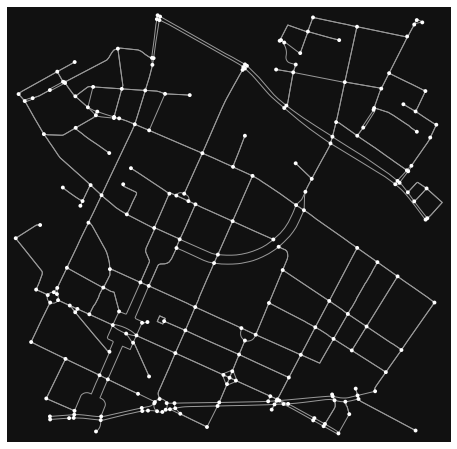

(<Figure size 576x576 with 1 Axes>, <Axes: >)

In [37]:
original_graph_berlin = load_berlin_road_network()
# copy the original graph for multiple simulations
berlin = nx.MultiDiGraph(original_graph_berlin)
berlin.add_edges_from(original_graph_berlin.edges)
plot_network(berlin)


In [38]:
num_cars = 10_000
duration = 60*60 # one hour
congestion_threshold = 0.75 # 75% of the road
num_simulations = 200

In [53]:
berlin_simulation = Traffic(berlin, num_cars,duration,congestion_threshold)
traffic_edges_berlin, congested_edges_berlin = berlin_simulation.simulation()

<ipython-input-51-0fcb636d48cd>:284: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


<Figure size 576x576 with 0 Axes>

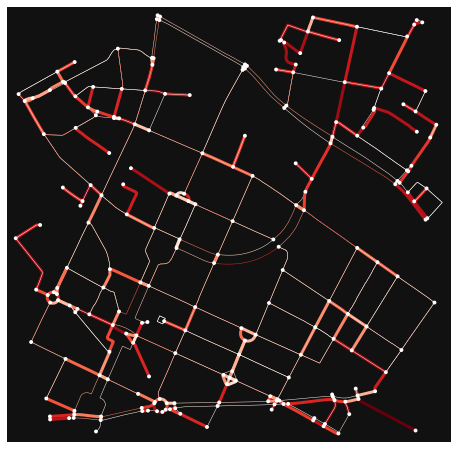

In [96]:
berlin_simulation.plot_traffic_on_graph(traffic_edges_berlin, congested_edges_berlin)

In [102]:
print(f'Step {duration}: Congested Edges: {len(congested_edges_berlin)} Congestion Density: {round(len(congested_edges_berlin)/len(traffic_edges_berlin)*100,2)}%')
print(f'This map has total {berlin.number_of_edges()} roads and {berlin.number_of_nodes()} locations.')


Step 3600: Congested Edges: 243 Congestion Density: 45.17%
This map has total 538 roads and 226 locations.


<Figure size 576x576 with 0 Axes>

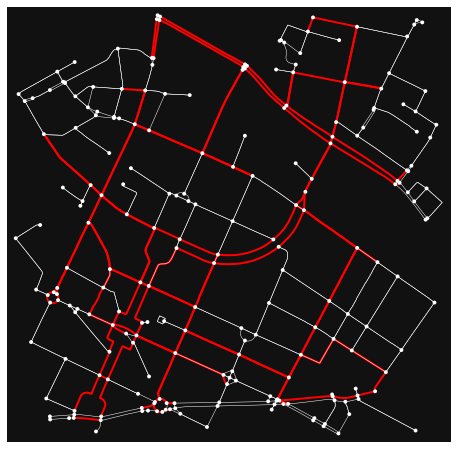

In [172]:
plot_edge_betweenness(berlin)


In [18]:
all_congested_edges_berlin = berlin_simulation.run_multiple_simulations(100)


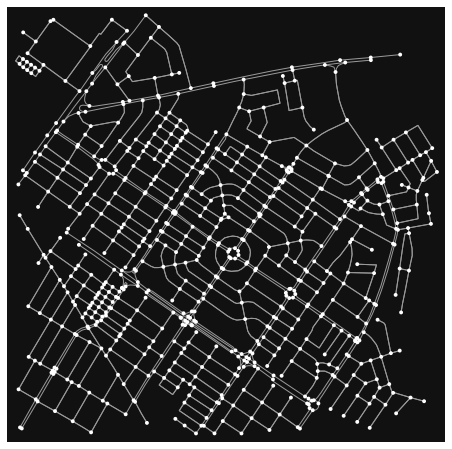

(<Figure size 576x576 with 1 Axes>, <Axes: >)

In [83]:
karachi_graph = ox.graph_from_address('Bahadurabad, Karachi, Pakistan', dist=1000, network_type='drive')
karachi = nx.MultiDiGraph(karachi_graph)
karachi.add_edges_from(karachi_graph.edges)
plot_network(karachi)

In [84]:
karachi_traffic_simulator = Traffic(karachi,num_cars,duration,congestion_threshold)
traffic_edges_karachi, congested_edges_karachi = karachi_traffic_simulator.simulation()



<ipython-input-75-38f36f01b809>:284: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


<Figure size 576x576 with 0 Axes>

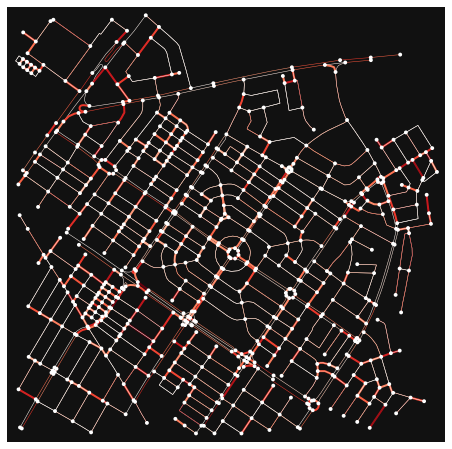

Step 3600: Congested Edges: 507 Congestion Density: 30.11%
This map has total 1684 roads and 686 locations.


In [101]:
karachi_traffic_simulator.plot_traffic_on_graph(traffic_edges_karachi, congested_edges_karachi)
print(f'Step {duration}: Congested Edges: {len(congested_edges_karachi)} Congestion Density: {round(len(congested_edges_karachi)/len(traffic_edges_karachi)*100,2)}%')
print(f'This map has total {karachi.number_of_edges()} roads and {karachi.number_of_nodes()} locations.')


<Figure size 576x576 with 0 Axes>

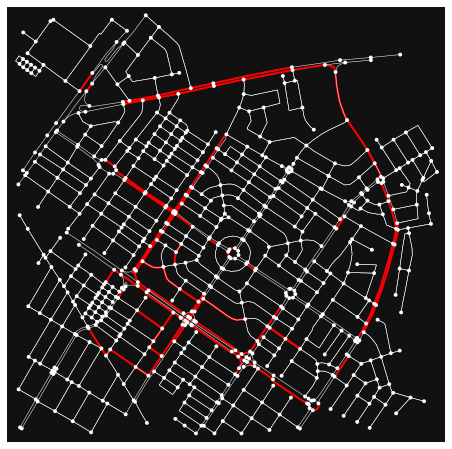

In [171]:
plot_edge_betweenness(karachi)

In [166]:
karachi_traffic_simulator = Traffic(karachi,10_000,3600,0.75)
all_congested_edges_karachi = []
        #print(all_congested_edges)

for _ in range(100):
    # initialize traffic dictionary
    traffic_edges, congested_edges = karachi_traffic_simulator.simulation()
    #print(congested_edges)
    #print(all_congested_edges)
    all_congested_edges_karachi.append(congested_edges)
    #print(all_congested_edges)
#print(all_congested_edges)

In [9]:
berlin_simulation = Traffic(berlin, num_cars,duration,congestion_threshold)
all_congested_edges = berlin_simulation.run_multiple_simulations(100)

In [169]:
edge_betweenness_berlin = nx.edge_betweenness_centrality(berlin)
aggregate_congestion_berlin = berlin_simulation.analyze_congestion(all_congested_edges)

edge_betweenness_karachi = nx.edge_betweenness_centrality(karachi)
aggregate_congestion_karachi = karachi_traffic_simulator.analyze_congestion(all_congested_edges_karachi)

<ipython-input-36-ca6c0ceaff60>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
<ipython-input-36-ca6c0ceaff60>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Edge Index')


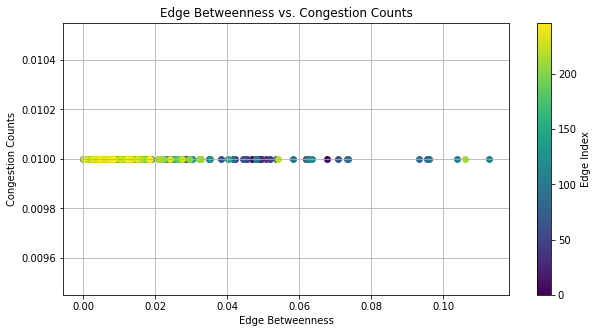

In [64]:
scatterplot_analysis(aggregate_congestion_berlin, edge_betweenness_berlin)

<ipython-input-154-6edd35effe31>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
<ipython-input-154-6edd35effe31>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Edge Index')


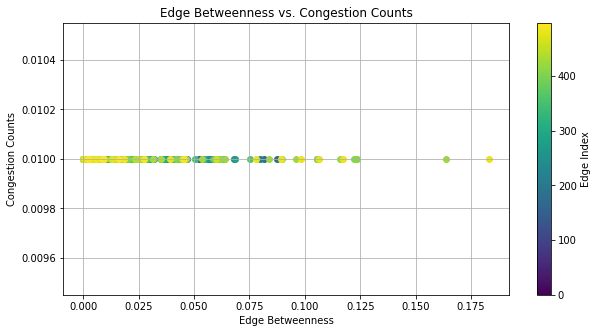

In [170]:
scatterplot_analysis(aggregate_congestion_karachi, edge_betweenness_karachi)